In [1]:
%matplotlib inline

In [2]:
import sys
import time
import numpy as np
import pandas as pd
import nibabel as nib
import pathlib as pal
import seaborn as sbn
from nilearn import surface
from nilearn import datasets
from nilearn import image as nimg
from sklearn import metrics as skm
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib.colors import ListedColormap

/home/surchs/conda/envs/svip/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [3]:
# Paths
root_p = pal.Path('/home/surchs/data/ATLAS/')
glasser360_p = root_p / 'Glasser/MMP_in_MNI_symmetrical_1.nii.gz'
mist20_p = root_p / 'MIST/Parcellations/MIST_20.nii.gz'
mist325_p = root_p / 'MIST/Parcellations/MIST_325.nii.gz'
mist444_p = root_p / 'MIST/Parcellations/MIST_444.nii.gz'
fig_p = pal.Path('/home/surchs/data/surchs/mist_parcellation/figures')

In [4]:
glasser360_i = nib.load(str(glasser360_p))
mist20_i = nib.load(str(mist20_p))
mist325_i = nib.load(str(mist325_p))
mist444_i = nib.load(str(mist444_p))

In [5]:
# Resample
mist20_res_i = nimg.resample_to_img(mist20_i, glasser360_i, interpolation='nearest')
mist325_res_i = nimg.resample_to_img(mist325_i, glasser360_i, interpolation='nearest')
mist444_res_i = nimg.resample_to_img(mist444_i, glasser360_i, interpolation='nearest')

In [6]:
# Get the parcellations and mask data
glasser360 = glasser360_i.get_data()

glasser_mask = np.zeros(glasser360.shape).astype(bool)
glasser_mask[glasser360!=0] = True

mist20 = mist20_res_i.get_data()
mist325 = mist325_res_i.get_data()
mist444 = mist444_res_i.get_data()

mist_mask = np.zeros(mist325.shape).astype(bool)
mist_mask[mist325!=0] = True

mist_mask20 = np.zeros(mist20.shape).astype(bool)
mist_mask20[mist20!=0] = True
# Also mask the cerebellum
mist_mask20[(mist20==4)|(mist20==17)] = False
# Also remove subcortical areas
mist_mask20[(mist20==1)|(mist20==10)] = False

## Build a consensus mask

In [7]:
consensus_mask = glasser_mask & mist_mask
consensus_mask_i = nib.Nifti1Image(consensus_mask, glasser360_i.affine, header=glasser360_i.header)

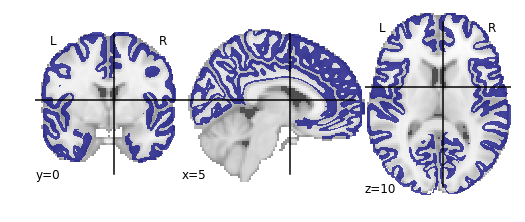

In [8]:
nlp.plot_roi(consensus_mask_i, cut_coords=(5, 0, 10));

In [9]:
# Mask the parcellations
glasser360_m = glasser360[consensus_mask]

mist325_m = mist325[consensus_mask]
mist444_m = mist444[consensus_mask]

## Compute percent overlap

In [10]:
def map_to_vol(values, mask):
    vol = np.zeros(mask.shape)
    vol[mask] = values
    return vol

In [11]:
def get_max_dice(reference, mask):
    candidates = np.unique(reference[mask])
    overlap = [skm.f1_score(reference==cand, mask) for cand in candidates]
    return np.max(overlap), candidates[np.argmax(overlap)]

In [12]:
def get_max_overlap(reference, mask):
    candidates = np.unique(reference[mask])
    n_voxel = np.sum(mask)
    overlap = [np.sum(mask[reference==cand])/n_voxel for cand in candidates]
    return np.max(overlap), candidates[np.argmax(overlap)]

In [13]:
def get_dice(to_test, to_compare):
    po_list = list()
    po_parcel_list = list()
    po_vol = np.zeros(to_test.shape)
    regions = np.unique(to_test)
    regions = regions[regions!=0]
    for region in regions:
        po, po_parcel = get_max_dice(to_compare, to_test==region)
        po_vol[to_test==region] = po
        po_list.append(po)
        po_parcel_list.append(po_parcel)
    return (po_vol, po_list, po_parcel_list)

In [14]:
def get_overlap(to_test, to_compare):
    po_list = list()
    po_parcel_list = list()
    po_vol = np.zeros(to_test.shape)
    regions = np.unique(to_test)
    regions = regions[regions!=0]
    for region in regions:
        po, po_parcel = get_max_overlap(to_compare, to_test==region)
        po_vol[to_test==region] = po
        po_list.append(po)
        po_parcel_list.append(po_parcel)
    return (po_vol, po_list, po_parcel_list)

In [15]:
po_glasser360_mist325, po_list_glasser360_mist325, po_parcel_list_glasser360_mist325 = get_overlap(mist325_m, glasser360_m)
po_glasser360_mist444, po_list_glasser360_mist444, po_parcel_list_glasser360_mist444 = get_overlap(mist444_m, glasser360_m)

f1_glasser360_mist325, f1_list_glasser360_mist325, f1_parcel_list_glasser360_mist325 = get_dice(mist325_m, glasser360_m)
f1_glasser360_mist444, f1_list_glasser360_mist444, f1_parcel_list_glasser360_mist444 = get_dice(mist444_m, glasser360_m)

In [16]:
po_glasser360_mist444, po_list_glasser360_mist444, po_parcel_list_glasser360_mist444 = get_overlap(mist444_m, glasser360_m)

In [17]:
# Map back to volume
po_vol_glasser360_mist325 = map_to_vol(po_glasser360_mist325, consensus_mask)
po_vol_glasser360_mist444 = map_to_vol(po_glasser360_mist444, consensus_mask)

f1_vol_glasser360_mist325 = map_to_vol(f1_glasser360_mist325, consensus_mask)
f1_vol_glasser360_mist444 = map_to_vol(f1_glasser360_mist444, consensus_mask)

In [18]:
po_img_glasser360_mist325 = nib.Nifti1Image(po_vol_glasser360_mist325, glasser360_i.affine, header=glasser360_i.header)
po_img_glasser360_mist444 = nib.Nifti1Image(po_vol_glasser360_mist444, glasser360_i.affine, header=glasser360_i.header)

f1_img_glasser360_mist325 = nib.Nifti1Image(f1_vol_glasser360_mist325, glasser360_i.affine, header=glasser360_i.header)
f1_img_glasser360_mist444 = nib.Nifti1Image(f1_vol_glasser360_mist444, glasser360_i.affine, header=glasser360_i.header)

## Detect the boundary region on the Glasser parcels

In [ ]:
def detect_borders(atlas, folds=1):
    start = time.time()
    touch_3d = np.array([[-1, 1, 0, 0, 0, 0],
                     [0, 0, -1, 1, 0, 0],
                     [0, 0, 0, 0, -1, 1]])
    
    test_atlas = np.copy(atlas)
    borders = np.zeros_like(test_atlas)
    atlas_inds = np.argwhere(test_atlas!=0)
    n_inds = len(atlas_inds)
    
    for fold in np.arange(folds):
        for coord_id, coord in enumerate(atlas_inds):
            neighbour_coords = tuple(map(tuple, (touch_3d.T+coord).T))
            # Find the difference between the coordinate and its neighbours
            neighbour_diff = np.setdiff1d(test_atlas[neighbour_coords], 
                                          test_atlas[tuple(coord)])
            # See if this coordinate touches borders
            if len(neighbour_diff[neighbour_diff!=0])>0:
                borders[tuple(coord)] = folds-fold
            if coord_id%10000==0 and not coord_id==0:
                elapsed = time.time() - start
                done = ((fold*n_inds)+coord_id)
                remaining = n_inds*folds - done
                time_left = (elapsed/done)*remaining
                sys.stdout.write('\r {:.2E}/{:.2E}. {:.2f}s left)'.format(done, n_inds*folds, time_left))
                sys.stdout.flush()
        test_atlas[borders!=0] = 999
    return borders

In [19]:
# Map the masked atlases back to volume space
glasser360_mask = map_to_vol(glasser360_m, consensus_mask)
mist325_mask = map_to_vol(mist325_m, consensus_mask)
mist444_mask = map_to_vol(mist444_m, consensus_mask)

glasser360_mask_i = nib.Nifti1Image(glasser360_mask, affine=glasser360_i.affine, header=glasser360_i.header)
mist325_mask_i = nib.Nifti1Image(mist325_mask, affine=glasser360_i.affine, header=glasser360_i.header)
mist444_mask_i = nib.Nifti1Image(mist444_mask, affine=glasser360_i.affine, header=glasser360_i.header)

Map the borders in the yeo image

In [25]:
borders_glasser360 = detect_borders(glasser360_mask, folds=2)

 1.17E+06/1.18E+06. 0.92s left)

In [26]:
borders_glasser360_i = nib.Nifti1Image(borders_glasser360, affine=glasser360_i.affine, header=glasser360_i.header)

## Plot the percent overlap

In [20]:
# Compute the DICE coefficients
dg360m444 = [[name, po] for name, po in zip(['po_g360m444']*len(po_list_glasser360_mist444), 
                                           po_list_glasser360_mist444)]

f1360m444 = [[name, dice] for name, dice in zip(['f1_g360m444']*len(f1_list_glasser360_mist444), 
                                           f1_list_glasser360_mist444)]


data = dg360m444 + f1360m444
dice = pd.DataFrame(data=data, columns=['comparison', 'dice'])

In [21]:
po_g360_m444 = np.array([list(e) for e in zip(np.unique(mist444_m), po_list_glasser360_mist444, po_parcel_list_glasser360_mist444)])

In [ ]:
colors = plt.cm.get_cmap('viridis_r').colors
new_colors = colors + colors[::-1]
double_viridis = ListedColormap(new_colors, name='double_viridis')

In [43]:
def make_column_figure(percent_overlap, borders, mist, mist_scale):
    f = plt.figure(figsize=(20,10))
    grids = gs.GridSpec(nrows=3, ncols=2, hspace=0.3, wspace=0)
    cuts = [
    (-5, 0, 0),
    (-40, -20, -10),
    (20, 30, 30)
    ]
    for i in range(3):
        ax_l = f.add_subplot(grids[i, 0])
        ax_r = f.add_subplot(grids[i, 1])

        display_left = nlp.plot_stat_map(percent_overlap, cut_coords=cuts[i], 
                                         draw_cross=False, cmap=double_viridis, axes=ax_l);

        display_right = nlp.plot_stat_map(borders, cut_coords=cuts[i], colorbar=False, cmap=plt.cm.viridis,
                                          draw_cross=False, axes=ax_r);

    return f

In [22]:
g360_size = np.array([np.sum(glasser360_m==roi) for roi in np.unique(glasser360_m)])
m444_size = np.array([np.sum(mist444_m==roi) for roi in np.unique(mist444_m)])

In [23]:
g360_size_all = np.array([np.sum(glasser360==roi) for roi in np.unique(glasser360[glasser360!=0])])
m444_size_all = np.array([np.sum(mist444==roi) for roi in np.unique(mist444[mist444!=0])])

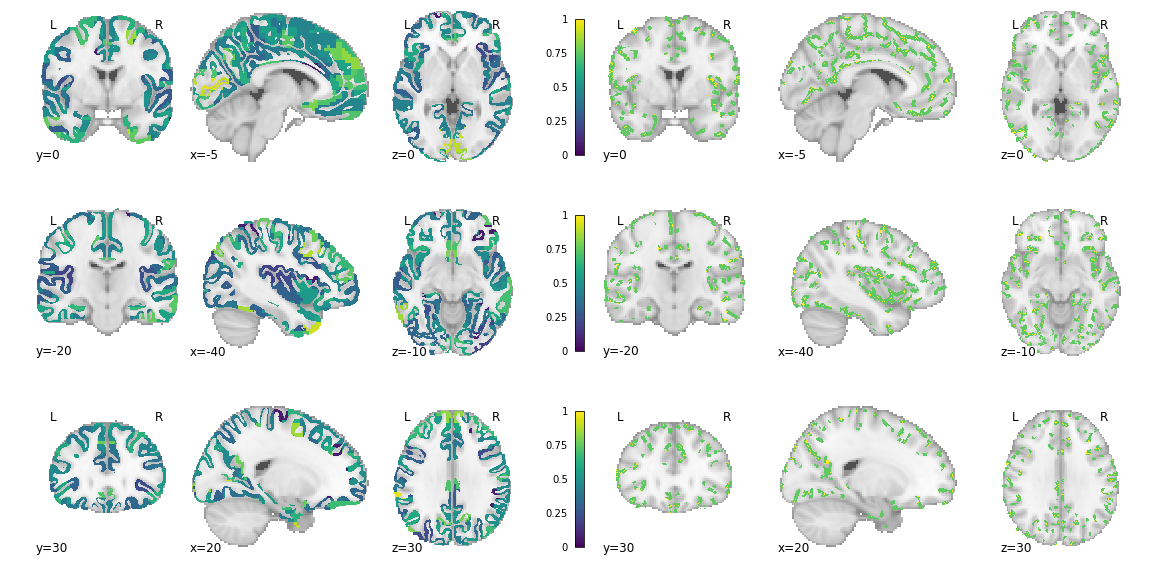

In [44]:
fig_glasser360_mist444 = make_column_figure(po_img_glasser360_mist444, borders_glasser360_i, mist444_mask_i, 444)

## Map onto the surface

In [24]:
fsaverage = datasets.fetch_surf_fsaverage5()

In [25]:
po_surf_glasser360_mist444_left = surface.vol_to_surf(po_img_glasser360_mist444, fsaverage.pial_left, interpolation='nearest', radius=10, mask_img=glasser360_mask_i)
po_surf_glasser360_mist444_right = surface.vol_to_surf(po_img_glasser360_mist444, fsaverage.pial_right, interpolation='nearest', radius=10, mask_img=glasser360_mask_i)

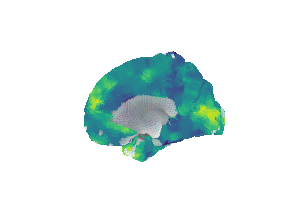

In [41]:
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111, **{'projection': '3d'})
nlp.plot_surf(fsaverage.pial_right, po_surf_glasser360_mist444_right, hemi='right', cmap=plt.cm.viridis,
                        colorbar=True, view='medial', vmax=1,
                        threshold=0, bg_map=fsaverage.sulc_right, alpha=0.5, axes=ax);
f.savefig(str(fig_p / 'glasser_reproducibility_right_med.pdf'), dpi=300, transparent=True)

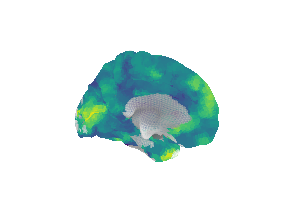

In [42]:
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111, **{'projection': '3d'})
nlp.plot_surf(fsaverage.pial_left, po_surf_glasser360_mist444_left, hemi='right', cmap=plt.cm.viridis,
                        colorbar=True, view='lateral', vmax=1,
                        threshold=0, bg_map=fsaverage.sulc_left, alpha=0.5, axes=ax);
f.savefig(str(fig_p / 'glasser_reproducibility_right_lat.pdf'), dpi=300, transparent=True)

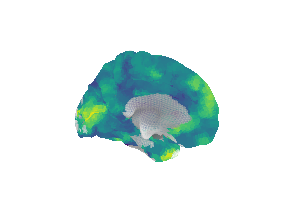

In [43]:
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111, **{'projection': '3d'})
nlp.plot_surf(fsaverage.pial_left, po_surf_glasser360_mist444_left, hemi='left', cmap=plt.cm.viridis,
                        colorbar=True, view='medial', vmax=1,
                        threshold=0, bg_map=fsaverage.sulc_left, alpha=0.5, axes=ax);
f.savefig(str(fig_p / 'glasser_reproducibility_left_med.pdf'), dpi=300, transparent=True)

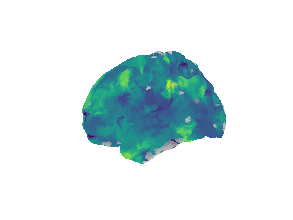

In [46]:
f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111, **{'projection': '3d'})
nlp.plot_surf(fsaverage.pial_left, po_surf_glasser360_mist444_left, hemi='left', cmap=plt.cm.viridis,
                        colorbar=True, view='lateral',vmax=1,
                        threshold=0, bg_map=fsaverage.sulc_left, alpha=0.5, axes=ax);
f.savefig(str(fig_p / 'glasser_reproducibility_left_lat.pdf'), dpi=300, transparent=True)